In [1]:
# %% [markdown]
# ## Cell 1: Imports and Setup
# 
# Import all the necessary libraries and set some paths.

# %% Code Cell
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from matplotlib.colors import LinearSegmentedColormap

# Set file paths (adjust these paths as needed)
data_path = "/Users/alexlawson/Masters-Data-Final/Morphoglia/PVN_all/Morphoglia/MorphoGlia/Data/Morphology_HDBSCAN_30_0.1_150_5_reformatted.csv"
plot_path = "/Users/alexlawson/Masters-Data-Final/Morphoglia/PVN_all/Morphoglia/MorphoGlia/Data/stats"

# Create the plot directory if it does not exist
os.makedirs(plot_path, exist_ok=True)


In [2]:
# %% [markdown]
# ## Cell 2: Load and Prepare Data
# 
# Read the CSV file, filter out rows where `Clusters == -1`, split by tissue, and adjust labeling.

# %% Code Cell
# Load the data
data = pd.read_csv(data_path)

# Filter out noise: remove rows where Clusters == -1
data = data[data['Clusters'] != -1]

# Split by tissue
data_M = data[data['tissue'] == "M"].copy()
data_F = data[data['tissue'] == "F"].copy()

# Create 'Cluster_Labels' column as a categorical variable
data_M['Cluster_Labels'] = data_M['Clusters'].astype('category')
data_F['Cluster_Labels'] = data_F['Clusters'].astype('category')

# Create a "categories" column by replacing underscores with spaces in treatment names
data_M['categories'] = data_M['treatment'].str.replace('_', ' ')
data_F['categories'] = data_F['treatment'].str.replace('_', ' ')

# Display a preview of the data
print("Males:")
print(data_M.head(), "\n")
print("Females:")
print(data_F.head())


Males:
   categories                  Cell_ID                    ID subject  group  \
51       COLD  C1_s04_MR140_COLD_M_PVN  PVN_MR140_COLD_M_s04     PVN  MR140   
52       COLD  C2_s04_MR140_COLD_M_PVN  PVN_MR140_COLD_M_s04     PVN  MR140   
53       COLD  C3_s04_MR140_COLD_M_PVN  PVN_MR140_COLD_M_s04     PVN  MR140   
54       COLD  C4_s04_MR140_COLD_M_PVN  PVN_MR140_COLD_M_s04     PVN  MR140   
55       COLD  C5_s04_MR140_COLD_M_PVN  PVN_MR140_COLD_M_s04     PVN  MR140   

   treatment tissue region  Cell          cell_positions  ...  \
51      COLD      M    s04     1  (1327, 562, 1409, 641)  ...   
52      COLD      M    s04     2  (3039, 624, 3088, 761)  ...   
53      COLD      M    s04     3  (1246, 630, 1355, 733)  ...   
54      COLD      M    s04     4  (1124, 662, 1228, 800)  ...   
55      COLD      M    s04     5   (994, 666, 1123, 797)  ...   

    Sholl_max_distance  Sholl_crossing_processes  Sholl_circles  \
51           60.108236                         9            

In [3]:
# %% [markdown]
# ## Cell 3: Contingency Tables & Chi-Square Tests
# 
# Create contingency tables (treatment vs. Clusters) and run chi‑square tests for both males and females. Then, compute the standardized residuals.

# %% Code Cell
# Contingency tables for Males and Females
contingency_table_M = pd.crosstab(data_M['treatment'], data_M['Clusters'])
contingency_table_F = pd.crosstab(data_F['treatment'], data_F['Clusters'])

print("Contingency Table - Males:")
print(contingency_table_M, "\n")
print("Contingency Table - Females:")
print(contingency_table_F, "\n")

# Chi-square test for Males
chi2_M, p_M, dof_M, expected_M = chi2_contingency(contingency_table_M)
# Standardized residuals = (observed - expected) / sqrt(expected)
residuals_M = (contingency_table_M.values - expected_M) / np.sqrt(expected_M)
residuals_M_df = pd.DataFrame(residuals_M, index=contingency_table_M.index, columns=contingency_table_M.columns)
print("Chi-square residuals for Males:")
print(residuals_M_df, "\n")

# Chi-square test for Females
chi2_F, p_F, dof_F, expected_F = chi2_contingency(contingency_table_F)
residuals_F = (contingency_table_F.values - expected_F) / np.sqrt(expected_F)
residuals_F_df = pd.DataFrame(residuals_F, index=contingency_table_F.index, columns=contingency_table_F.columns)
print("Chi-square residuals for Females:")
print(residuals_F_df)


Contingency Table - Males:
Clusters     0    1   2    3   4
treatment                       
COLD        76   96  49  141  45
CON        114  109  40  125  41 

Contingency Table - Females:
Clusters     0    1   2    3   4
treatment                       
COLD       105  116  56  167  54
CON        114  123  59  180  50 

Chi-square residuals for Males:
Clusters          0         1         2         3         4
treatment                                                  
COLD      -1.715588 -0.380639  0.861538  1.010562  0.483972
CON        1.671020  0.370751 -0.839157 -0.984309 -0.471399 

Chi-square residuals for Females:
Clusters          0         1         2         3         4
treatment                                                  
COLD      -0.145914 -0.021558  0.009663 -0.135164  0.481153
CON        0.141977  0.020977 -0.009402  0.131517 -0.468171


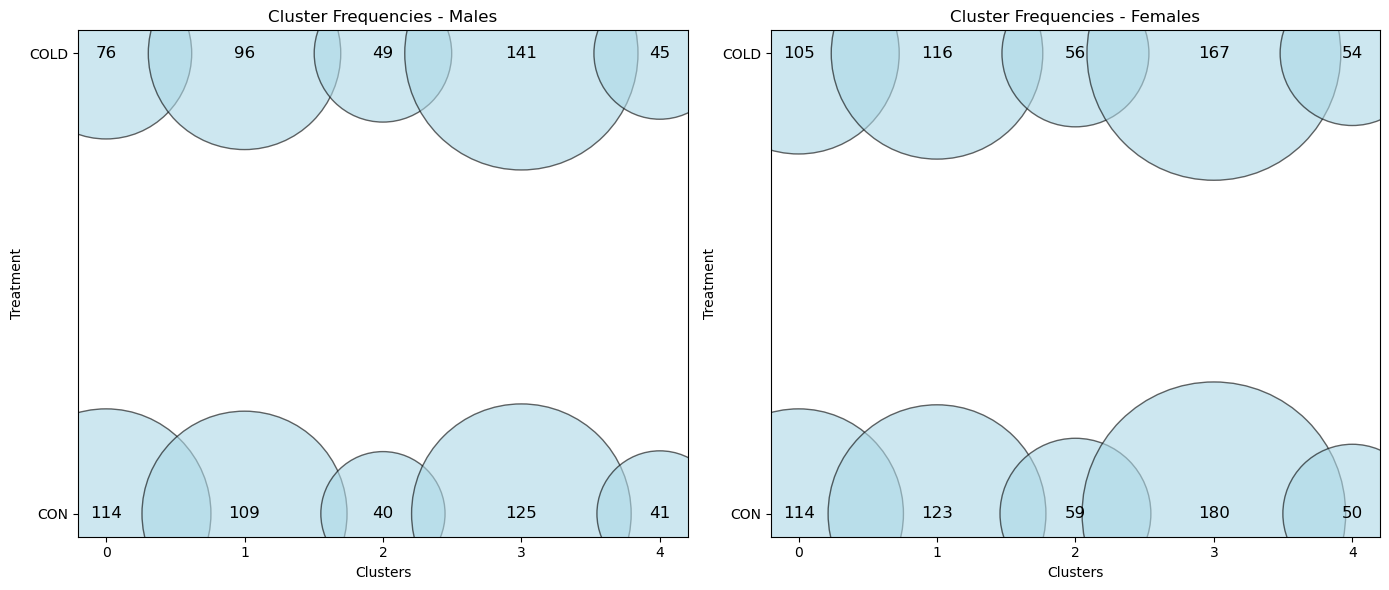

Balloon plots saved to: /Users/alexlawson/Masters-Data-Final/Morphoglia/PVN_all/Morphoglia/MorphoGlia/Data/stats/Cluster_Frequencies_M_and_F.png


In [4]:
# %% [markdown]
# ## Cell 4: Balloon Plots for Cluster Frequencies
# 
# Create side‑by‑side balloon plots for both males and females. In a balloon plot, the bubble size is proportional to the frequency and each bubble is annotated with the count.

# %% Code Cell
def create_balloon_plot(contingency_table, title, ax):
    # Get labels and data
    x_labels = list(contingency_table.columns.astype(str))
    y_labels = list(contingency_table.index.astype(str))
    counts = contingency_table.values
    
    # Create meshgrid for positions
    x, y = np.meshgrid(np.arange(len(x_labels)), np.arange(len(y_labels)))
    
    # Flatten for plotting
    x_flat = x.flatten()
    y_flat = y.flatten()
    counts_flat = counts.flatten()
    
    # Set scaling for bubble sizes (adjust as needed)
    scale = 200  
    sizes = counts_flat * scale
    
    # Plot the bubbles
    ax.scatter(x_flat, y_flat, s=sizes, color='lightblue', alpha=0.6, edgecolors='black')
    
    # Annotate each bubble with the count
    for (i, j, count) in zip(x_flat, y_flat, counts_flat):
        ax.text(i, j, str(count), ha='center', va='center', fontsize=12)
    
    # Set ticks and labels
    ax.set_xticks(np.arange(len(x_labels)))
    ax.set_xticklabels(x_labels)
    ax.set_yticks(np.arange(len(y_labels)))
    ax.set_yticklabels(y_labels)
    ax.set_xlabel("Clusters")
    ax.set_ylabel("Treatment")
    ax.set_title(title)
    ax.invert_yaxis()  # Invert y-axis for a typical balloonplot appearance

# Create a figure for balloon plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

create_balloon_plot(contingency_table_M, "Cluster Frequencies - Males", ax1)
create_balloon_plot(contingency_table_F, "Cluster Frequencies - Females", ax2)

plt.tight_layout()
balloon_plot_file = os.path.join(plot_path, "Cluster_Frequencies_M_and_F.png")
plt.savefig(balloon_plot_file, dpi=300)
plt.show()

print(f"Balloon plots saved to: {balloon_plot_file}")


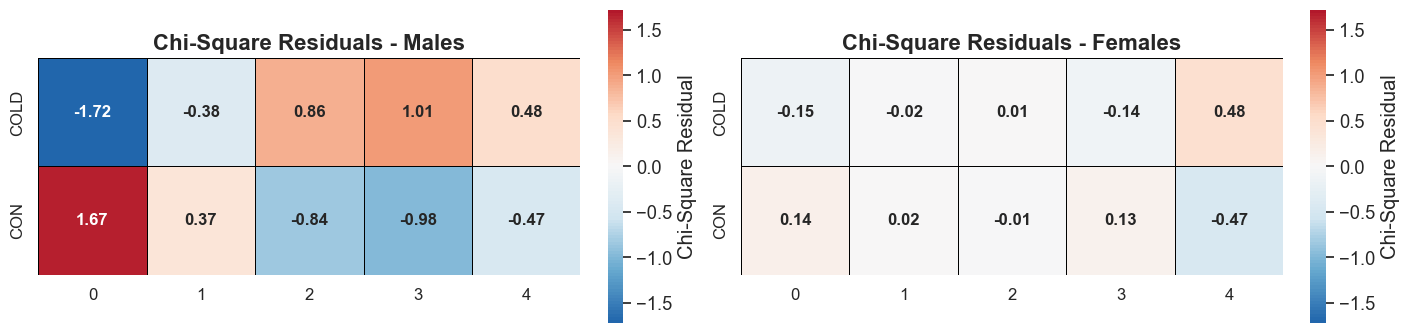

Heatmaps saved to: /Users/alexlawson/Masters-Data-Final/Morphoglia/PVN_all/Morphoglia/MorphoGlia/Data/stats/Chi_Square_Residuals_M_and_F_stylish.png


In [27]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Set the plot_path appropriately (you already defined plot_path)
# For example:
# plot_path = "/Users/alexlawson/Masters-Data-Final/Morphoglia/PVN_all/Morphoglia/MorphoGlia/Data/Plots"

# Set universal scale limits
vmin, vmax = -1.72, 1.72

# Create a custom diverging color palette
colors = [
    "#2166AC",  # Deep blue (strong negative)
    "#67A9CF",  # Soft blue
    "#D1E5F0",  # Very pale blue
    "#F7F7F7",  # White (neutral midpoint)
    "#FDDBC7",  # Very pale red
    "#EF8A62",  # Medium red
    "#B2182B"   # Deep red (strong positive)
]
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=100)

# Set Seaborn theme for a cleaner look
sns.set_theme(style="white", font_scale=1.2)

# Create subplots for the male and female heatmaps (side-by-side)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4), constrained_layout=True)

# Plot the heatmap for male residuals with enhanced aesthetics
sns.heatmap(residuals_M_df,
            cmap=custom_cmap,
            annot=True,
            fmt=".2f",
            vmin=vmin,
            vmax=vmax,
            linewidths=0.7,
            linecolor='black',
            cbar=True,
            ax=ax1,
            square=True,
            annot_kws={'fontsize':12, 'weight':'bold'},
            cbar_kws={'shrink': 0.8, 'label': 'Chi-Square Residual'}
           )
ax1.set_title("Chi-Square Residuals - Males", fontsize=16, fontweight='bold')
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.set_xlabel("")
ax1.set_ylabel("")

# Plot the heatmap for female residuals with similar formatting
sns.heatmap(residuals_F_df,
            cmap=custom_cmap,
            annot=True,
            fmt=".2f",
            vmin=vmin,
            vmax=vmax,
            linewidths=0.7,
            linecolor='black',
            cbar=True,
            ax=ax2,
            square=True,
            annot_kws={'fontsize':12, 'weight':'bold'},
            cbar_kws={'shrink': 0.8, 'label': 'Chi-Square Residual'}
           )
ax2.set_title("Chi-Square Residuals - Females", fontsize=16, fontweight='bold')
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.set_xlabel("")
ax2.set_ylabel("")

# Save the resulting plot in the defined directory
heatmap_file = os.path.join(plot_path, "Chi_Square_Residuals_M_and_F_stylish.png")
plt.savefig(heatmap_file, dpi=300)
plt.show()

print(f"Heatmaps saved to: {heatmap_file}")



/var/folders/54/7byrywl93ynbd42k_q4n9b6w0000gn/T/ipykernel_36700/759007271.py:71: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 2.32388322e-01  5.25729353e-02  1.05690766e+00  1.77470729e+00
  5.04304273e-01 -8.70625576e-01  2.42379698e+00  2.40428848e-01
  1.26399578e-01  9.70654748e-01  4.60424129e+00 -5.42425947e-01
  2.36043107e-01 -9.37142650e-01 -8.01915631e-01 -5.81166660e-01
 -1.55749769e-01  1.84145170e-01  1.10318527e-01  6.57074257e-01
  9.32644992e-01  3.68346298e-01  1.11049484e-01 -4.02585856e-02
  2.21423969e-01  1.23599209e+00 -6.41105123e-01 -5.38040206e-01
  8.10802528e-02 -7.16393679e-01  6.34414594e-01 -6.82769663e-01
  8.20808593e-01 -5.49735515e-01 -4.53980167e-01  2.17769185e-01
 -6.79114879e-01 -2.26652584e-01 -5.09532888e-01 -7.82910753e-01
 -1.87180914e-01 -1.33090107e-01 -3.18753148e-01  4.79451740e-01
 -1.18128224e+00  5.68628477e-01  8.12768067e-01 -1.58673597e-01
 -1.14546535e+00 -7.

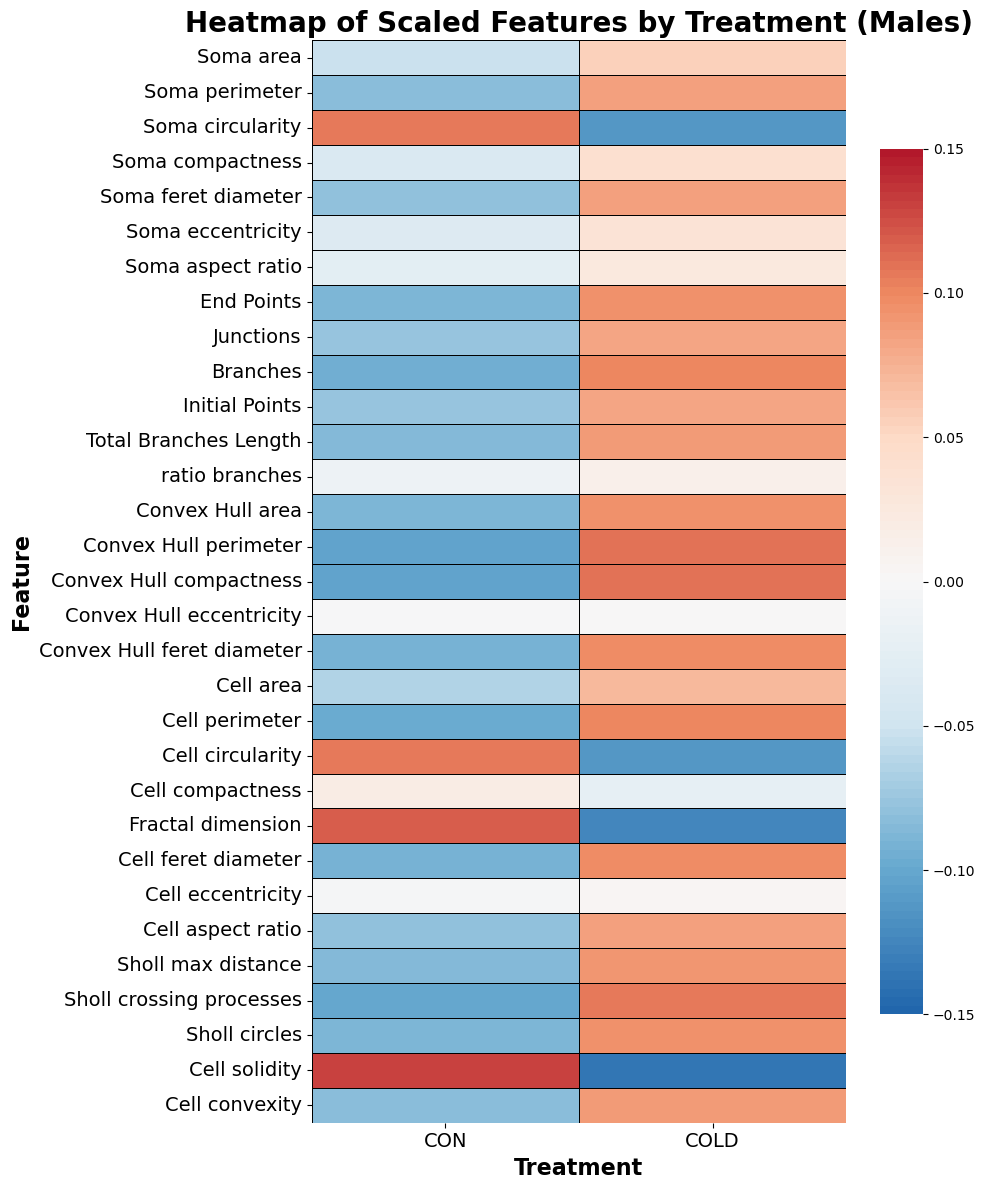

Heatmap saved to: /Users/alexlawson/Masters-Data-Final/Morphoglia/PVN_all/Morphoglia/MorphoGlia/Data/Plots/Heatmap_Python/heatmap_treatment_Males.png


In [15]:
# %% [markdown]
# # Heatmap of Scaled Features by Treatment (Males)
# This notebook creates a heatmap of scaled morphological features for male samples.
# The data are first aggregated by "treatment" (which plays the role of cluster here),
# then transposed so that rows are features and columns are treatment groups.
# A fixed diverging color scale (from -1 to 1) is used.

# %% [code]
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import LinearSegmentedColormap

# Set file paths (adjust these paths as needed)
data_path = "/Users/alexlawson/Masters-Data-Final/Morphoglia/PVN_all/Morphoglia/MorphoGlia/Data/Morphology_HDBSCAN_30_0.1_150_5_reformatted.csv"
output_dir = "/Users/alexlawson/Masters-Data-Final/Morphoglia/PVN_all/Morphoglia/MorphoGlia/Data/Plots/Heatmap_Python"
os.makedirs(output_dir, exist_ok=True)

# %% [markdown]
# ## Load and Filter Data

# %% [code]
# Load the CSV data
df = pd.read_csv(data_path)

# Remove noise: filter out rows where Clusters equals -1
df = df[df['Clusters'] != -1]

# Filter for Males
df = df[df['tissue'] == "M"].copy()

# %% [markdown]
# ## Select and Prepare Variables
# We will use a set of feature variables. In this example they are:
# 
# - Soma_area, Soma_perimeter, Soma_circularity, …, Cell_convexity  
# 
# Replace underscores in variable names with spaces for nicer labels.

# %% [code]
# List of variables to be used
variables = [
    'Soma_area', 'Soma_perimeter', 'Soma_circularity', 'Soma_compactness', 
    'Soma_feret_diameter', 'Soma_eccentricity', 'Soma_aspect_ratio', 
    'End_Points', 'Junctions', 'Branches', 'Initial_Points', 'Total_Branches_Length', 
    'ratio_branches', 'Convex_Hull_area', 'Convex_Hull_perimeter', 
    'Convex_Hull_compactness', 'Convex_Hull_eccentricity', 'Convex_Hull_feret_diameter',
    'Cell_area', 'Cell_perimeter', 'Cell_circularity', 'Cell_compactness', 'Fractal_dimension',
    'Cell_feret_diameter', 'Cell_eccentricity', 'Cell_aspect_ratio', 'Sholl_max_distance', 
    'Sholl_crossing_processes', 'Sholl_circles', 'Cell_solidity', 'Cell_convexity'
]

# Subset the data: keep treatment and the selected variables
df_filtered = df[['treatment'] + variables].copy()

# Replace underscores with spaces in the variable names (for prettier row names)
new_labels = [var.replace("_", " ") for var in variables]
df_filtered.columns = ['treatment'] + new_labels

# %% [markdown]
# ## Scale the Data and Aggregate by Treatment
# We'll scale each numeric column (z‑score) and then compute the average for each treatment group.

# %% [code]
# Scale numeric columns (all except "treatment")
scaler = StandardScaler()
df_scaled = df_filtered.copy()
df_scaled.iloc[:, 1:] = scaler.fit_transform(df_scaled.iloc[:, 1:])

# Group by treatment and take the mean for each feature
agg_data = df_scaled.groupby('treatment', as_index=False).mean()

# Optionally, sort the treatments. For instance, if you want a manual order:
desired_order = []
if "CON" in agg_data['treatment'].values and "COLD" in agg_data['treatment'].values:
    desired_order = ["CON", "COLD"]
else:
    desired_order = sorted(agg_data['treatment'].unique())
agg_data = agg_data.set_index('treatment').loc[desired_order].reset_index()

# %% [markdown]
# ## Transpose Data for Heatmap
# Now we have features as rows and treatment groups as columns.

# %% [code]
# Create a matrix for the heatmap: rows = features, columns = treatment groups
heatmap_data = agg_data.set_index('treatment').T
# The row indices are feature labels (already in new_labels order)
# The column names are treatment groups (ordered as desired)

# %% [markdown]
# ## Define a Uniform Diverging Color Scale
# We use a custom colormap based on a smooth transition from blue → white → red.
# The color range is fixed from -1 to 1.

# %% [code]
colors = [
    "#2166AC",  # Deep blue
    "#67A9CF",  # Mid blue
    "#D1E5F0",  # Pale blue
    "#F7F7F7",  # White (neutral midpoint)
    "#FDDBC7",  # Pale red
    "#EF8A62",  # Medium red
    "#B2182B"   # Deep red
]
custom_cmap = LinearSegmentedColormap.from_list("custom_diverging", colors, N=100)
vmin, vmax = -0.15, 0.15

# %% [markdown]
# ## Plot the Heatmap
# We use seaborn’s heatmap. Adjust font sizes as desired.

# %% [code]
plt.figure(figsize=(10, 12))
ax = sns.heatmap(heatmap_data, cmap=custom_cmap, annot=False, fmt=".2f",
                 vmin=vmin, vmax=vmax, linewidths=0.5, linecolor='black',
                 cbar_kws={'shrink': 0.8})

ax.set_title("Heatmap of Scaled Features by Treatment (Males)",
             fontsize=20, fontweight='bold')
ax.set_xlabel("Treatment", fontsize=16, fontweight='bold')
ax.set_ylabel("Feature", fontsize=16, fontweight='bold')
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
plt.tight_layout()

# Save the figure
output_file = os.path.join(output_dir, "heatmap_treatment_Males.png")
plt.savefig(output_file, dpi=300)
plt.show()

print("Heatmap saved to:", output_file)


/var/folders/54/7byrywl93ynbd42k_q4n9b6w0000gn/T/ipykernel_36700/1543879437.py:71: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.18513213 -0.76880937 -0.6781858  ...  0.56596833 -1.56598961
 -0.55607438]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_scaled.iloc[:, 1:] = scaler.fit_transform(df_scaled.iloc[:, 1:])
/var/folders/54/7byrywl93ynbd42k_q4n9b6w0000gn/T/ipykernel_36700/1543879437.py:71: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-1.021252   -0.72758111 -0.72758111 ... -0.14023932  0.15343157
 -1.31492289]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_scaled.iloc[:, 1:] = scaler.fit_transform(df_scaled.iloc[:, 1:])
/var/folders/54/7byrywl93ynbd42k_q4n9b6w0000gn/T/ipykernel_36700/1543879437.py:71: FutureWarning: Setting an item of incompa

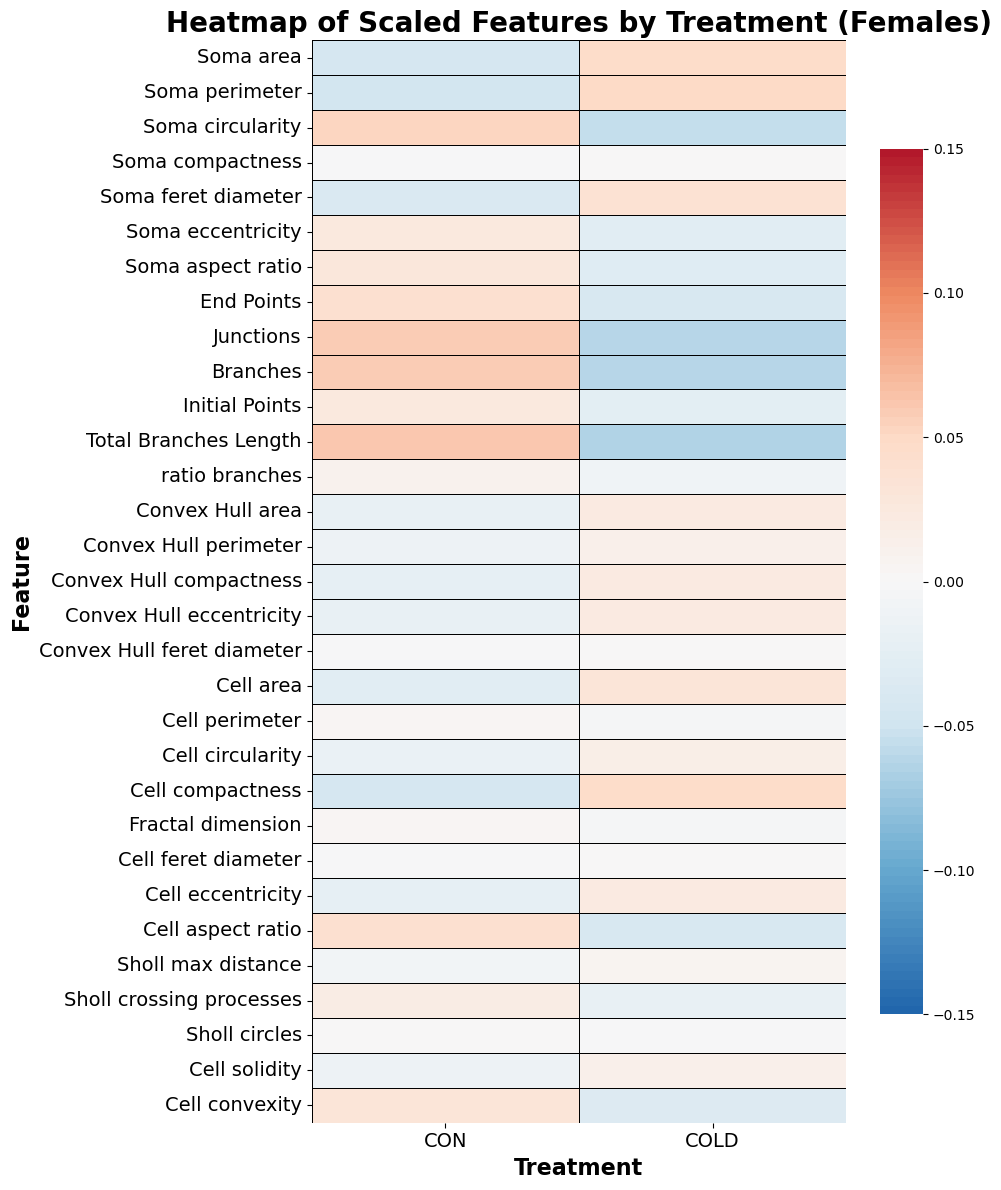

Heatmap saved to: /Users/alexlawson/Masters-Data-Final/Morphoglia/PVN_all/Morphoglia/MorphoGlia/Data/Plots/Heatmap_Python/heatmap_treatment_Females.png


In [16]:
# %% [markdown]
# # Heatmap of Scaled Features by Treatment (Males)
# This notebook creates a heatmap of scaled morphological features for male samples.
# The data are first aggregated by "treatment" (which plays the role of cluster here),
# then transposed so that rows are features and columns are treatment groups.
# A fixed diverging color scale (from -1 to 1) is used.

# %% [code]
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import LinearSegmentedColormap

# Set file paths (adjust these paths as needed)
data_path = "/Users/alexlawson/Masters-Data-Final/Morphoglia/PVN_all/Morphoglia/MorphoGlia/Data/Morphology_HDBSCAN_30_0.1_150_5_reformatted.csv"
output_dir = "/Users/alexlawson/Masters-Data-Final/Morphoglia/PVN_all/Morphoglia/MorphoGlia/Data/Plots/Heatmap_Python"
os.makedirs(output_dir, exist_ok=True)

# %% [markdown]
# ## Load and Filter Data

# %% [code]
# Load the CSV data
df = pd.read_csv(data_path)

# Remove noise: filter out rows where Clusters equals -1
df = df[df['Clusters'] != -1]

# Filter for Males
df = df[df['tissue'] == "F"].copy()

# %% [markdown]
# ## Select and Prepare Variables
# We will use a set of feature variables. In this example they are:
# 
# - Soma_area, Soma_perimeter, Soma_circularity, …, Cell_convexity  
# 
# Replace underscores in variable names with spaces for nicer labels.

# %% [code]
# List of variables to be used
variables = [
    'Soma_area', 'Soma_perimeter', 'Soma_circularity', 'Soma_compactness', 
    'Soma_feret_diameter', 'Soma_eccentricity', 'Soma_aspect_ratio', 
    'End_Points', 'Junctions', 'Branches', 'Initial_Points', 'Total_Branches_Length', 
    'ratio_branches', 'Convex_Hull_area', 'Convex_Hull_perimeter', 
    'Convex_Hull_compactness', 'Convex_Hull_eccentricity', 'Convex_Hull_feret_diameter',
    'Cell_area', 'Cell_perimeter', 'Cell_circularity', 'Cell_compactness', 'Fractal_dimension',
    'Cell_feret_diameter', 'Cell_eccentricity', 'Cell_aspect_ratio', 'Sholl_max_distance', 
    'Sholl_crossing_processes', 'Sholl_circles', 'Cell_solidity', 'Cell_convexity'
]

# Subset the data: keep treatment and the selected variables
df_filtered = df[['treatment'] + variables].copy()

# Replace underscores with spaces in the variable names (for prettier row names)
new_labels = [var.replace("_", " ") for var in variables]
df_filtered.columns = ['treatment'] + new_labels

# %% [markdown]
# ## Scale the Data and Aggregate by Treatment
# We'll scale each numeric column (z‑score) and then compute the average for each treatment group.

# %% [code]
# Scale numeric columns (all except "treatment")
scaler = StandardScaler()
df_scaled = df_filtered.copy()
df_scaled.iloc[:, 1:] = scaler.fit_transform(df_scaled.iloc[:, 1:])

# Group by treatment and take the mean for each feature
agg_data = df_scaled.groupby('treatment', as_index=False).mean()

# Optionally, sort the treatments. For instance, if you want a manual order:
desired_order = []
if "CON" in agg_data['treatment'].values and "COLD" in agg_data['treatment'].values:
    desired_order = ["CON", "COLD"]
else:
    desired_order = sorted(agg_data['treatment'].unique())
agg_data = agg_data.set_index('treatment').loc[desired_order].reset_index()

# %% [markdown]
# ## Transpose Data for Heatmap
# Now we have features as rows and treatment groups as columns.

# %% [code]
# Create a matrix for the heatmap: rows = features, columns = treatment groups
heatmap_data = agg_data.set_index('treatment').T
# The row indices are feature labels (already in new_labels order)
# The column names are treatment groups (ordered as desired)

# %% [markdown]
# ## Define a Uniform Diverging Color Scale
# We use a custom colormap based on a smooth transition from blue → white → red.
# The color range is fixed from -1 to 1.

# %% [code]
colors = [
    "#2166AC",  # Deep blue
    "#67A9CF",  # Mid blue
    "#D1E5F0",  # Pale blue
    "#F7F7F7",  # White (neutral midpoint)
    "#FDDBC7",  # Pale red
    "#EF8A62",  # Medium red
    "#B2182B"   # Deep red
]
custom_cmap = LinearSegmentedColormap.from_list("custom_diverging", colors, N=100)
vmin, vmax = -0.15, 0.15

# %% [markdown]
# ## Plot the Heatmap
# We use seaborn’s heatmap. Adjust font sizes as desired.

# %% [code]
plt.figure(figsize=(10, 12))
ax = sns.heatmap(heatmap_data, cmap=custom_cmap, annot=False, fmt=".2f",
                 vmin=vmin, vmax=vmax, linewidths=0.5, linecolor='black',
                 cbar_kws={'shrink': 0.8})

ax.set_title("Heatmap of Scaled Features by Treatment (Females)",
             fontsize=20, fontweight='bold')
ax.set_xlabel("Treatment", fontsize=16, fontweight='bold')
ax.set_ylabel("Feature", fontsize=16, fontweight='bold')
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
plt.tight_layout()

# Save the figure
output_file = os.path.join(output_dir, "heatmap_treatment_Females.png")
plt.savefig(output_file, dpi=300)
plt.show()

print("Heatmap saved to:", output_file)


/var/folders/54/7byrywl93ynbd42k_q4n9b6w0000gn/T/ipykernel_36700/987844458.py:70: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.17387001 -0.74435902 -0.6557831  ...  0.56025928 -1.52352692
 -0.53643079]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_scaled.iloc[:, 1:] = scaler.fit_transform(df_scaled.iloc[:, 1:])
/var/folders/54/7byrywl93ynbd42k_q4n9b6w0000gn/T/ipykernel_36700/987844458.py:70: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.99859101 -0.70909923 -0.70909923 ... -0.13011566  0.15937612
 -1.28808279]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_scaled.iloc[:, 1:] = scaler.fit_transform(df_scaled.iloc[:, 1:])
/var/folders/54/7byrywl93ynbd42k_q4n9b6w0000gn/T/ipykernel_36700/987844458.py:70: FutureWarning: Setting an item of incompatib

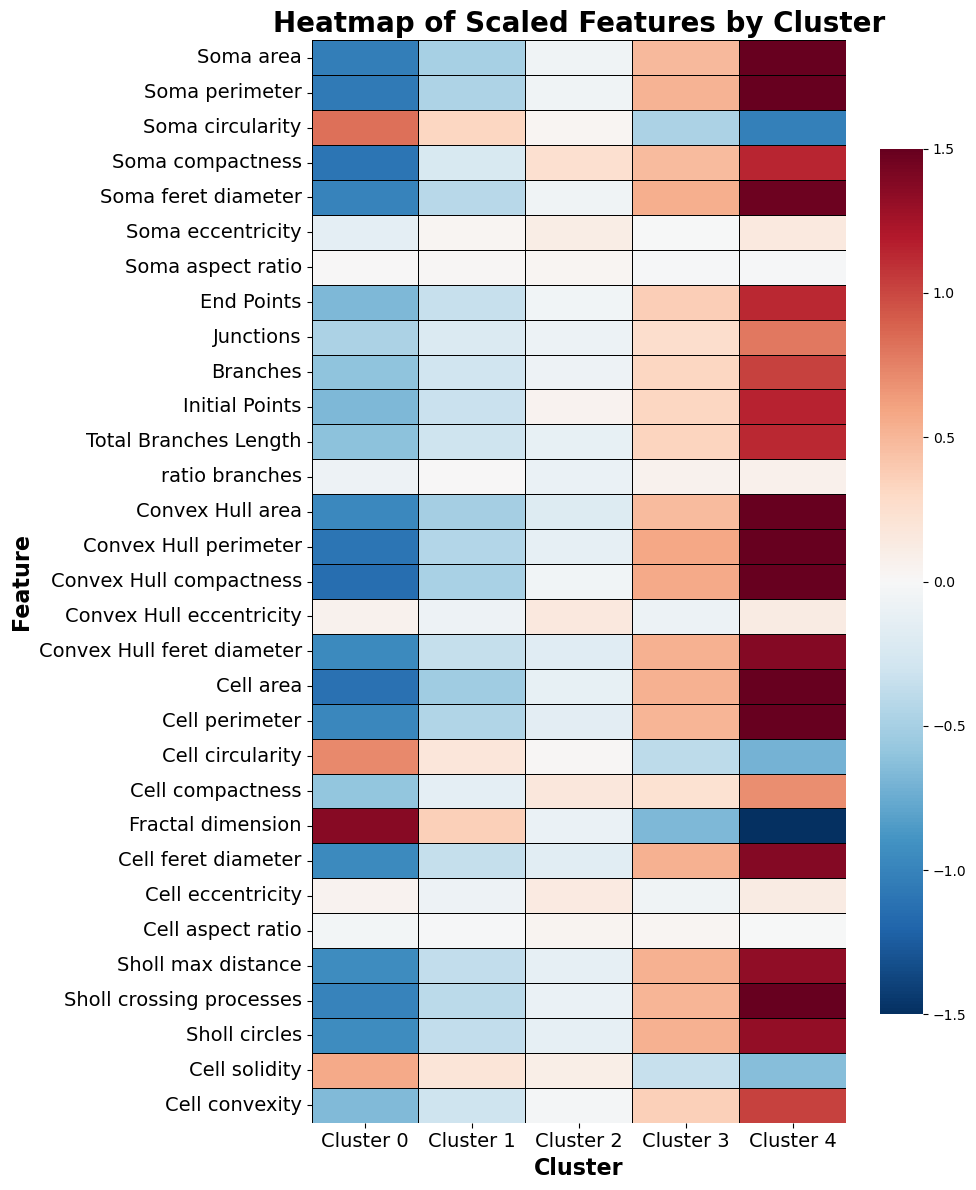

Heatmap saved to: /Users/alexlawson/Masters-Data-Final/Morphoglia/PVN_all/Morphoglia/MorphoGlia/Data/Plots/Heatmap_Python/heatmap_with_dendrogram_Clusters-ALLnew.png


In [23]:
# %% [markdown]
# # Heatmap of Scaled Features by Cluster (All Samples)
# 
# This notebook creates a heatmap of scaled morphological features, aggregated by **Cluster**.
# Data are first filtered to remove noise (Clusters = -1). A defined set of features is scaled (z‑scored)
# and then averaged by Cluster. The heatmap displays features (rows) versus clusters (columns),
# using a fixed diverging color scale from –1 to 1 (using the "RdBu_r" palette).
# The resulting plot is saved to the specified output directory.

# %% [code]
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Set file paths (adjust these paths as needed)
data_path = "/Users/alexlawson/Masters-Data-Final/Morphoglia/PVN_all/Morphoglia/MorphoGlia/Data/Morphology_HDBSCAN_30_0.1_150_5_reformatted.csv"
output_dir = "/Users/alexlawson/Masters-Data-Final/Morphoglia/PVN_all/Morphoglia/MorphoGlia/Data/Plots/Heatmap_Python"
os.makedirs(output_dir, exist_ok=True)

# %% [markdown]
# ## Load and Prepare the Data
# 
# • Read the CSV file  
# • Filter out rows where `Clusters` is -1  
# • Subset the data to include only the columns "Clusters" and the desired features

# %% [code]
# Load the CSV file
df = pd.read_csv(data_path)

# Filter out noise (Clusters == -1)
df = df[df['Clusters'] != -1].copy()

# Define the variables to be used in the heatmap
variables = [
    'Soma_area', 'Soma_perimeter', 'Soma_circularity', 'Soma_compactness', 
    'Soma_feret_diameter', 'Soma_eccentricity', 'Soma_aspect_ratio', 
    'End_Points', 'Junctions', 'Branches', 'Initial_Points', 'Total_Branches_Length', 
    'ratio_branches', 'Convex_Hull_area', 'Convex_Hull_perimeter', 
    'Convex_Hull_compactness', 'Convex_Hull_eccentricity', 'Convex_Hull_feret_diameter',
    'Cell_area', 'Cell_perimeter', 'Cell_circularity', 'Cell_compactness', 'Fractal_dimension',
    'Cell_feret_diameter', 'Cell_eccentricity', 'Cell_aspect_ratio', 'Sholl_max_distance', 
    'Sholl_crossing_processes', 'Sholl_circles', 'Cell_solidity', 'Cell_convexity'
]

# Subset the data to include only "Clusters" and the selected variables
df_filtered = df[['Clusters'] + variables].copy()

# Replace underscores with spaces for feature names, keeping "Clusters" as is
new_attribute_labels = [var.replace("_", " ") for var in variables]
df_filtered.columns = ['Clusters'] + new_attribute_labels

# Ensure that the Clusters column is categorical with the order: 0, 1, 2, 3, 4
df_filtered['Clusters'] = pd.Categorical(df_filtered['Clusters'], categories=[0, 1, 2, 3, 4], ordered=True)

# %% [markdown]
# ## Scaling and Aggregation
# 
# • Scale (z‑score) each feature (all columns except Clusters)  
# • Group by Cluster and compute the mean for each feature  
# • Sort the aggregated data by Cluster

# %% [code]
# Scale the numeric features (all columns except "Clusters")
scaler = StandardScaler()
df_scaled = df_filtered.copy()
df_scaled.iloc[:, 1:] = scaler.fit_transform(df_scaled.iloc[:, 1:])

# Aggregate the data by Cluster (taking the mean for each feature)
agg_data = df_scaled.groupby('Clusters', as_index=False).mean()

# Ensure the clusters are sorted (they should follow 0, 1, 2, 3, 4)
agg_data = agg_data.sort_values('Clusters')

# %% [markdown]
# ## Transpose the Data for the Heatmap
# 
# We want features as rows and Clusters as columns. We also rename the columns to "Cluster 0", "Cluster 1", etc.

# %% [code]
# Transpose: rows become features, columns become clusters
heatmap_data = agg_data.set_index('Clusters').T

# Rename the columns to include the word "Cluster"
heatmap_data.columns = ["Cluster " + str(c) for c in heatmap_data.columns]
# The row indices now match new_attribute_labels

# %% [markdown]
# ## Define the Diverging Color Scale
# 
# We use a fixed diverging color scale from -1 to 1. Here we use the built-in "RdBu_r" colormap,
# which gives blue for low values, white at the midpoint, and red for high values.

# %% [code]
cmap = plt.get_cmap("RdBu_r")
vmin, vmax = -1.5, 1.5

# %% [markdown]
# ## Plot and Save the Heatmap
# 
# We use Seaborn's heatmap to plot the data with annotations. Adjust the figure size and font sizes as desired.
# The resulting plot is saved as a PNG in the output directory.

# %% [code]
plt.figure(figsize=(10, 12))
ax = sns.heatmap(heatmap_data, cmap=cmap, annot=False, fmt=".2f",
                 vmin=vmin, vmax=vmax, linewidths=0.5, linecolor='black',
                 cbar_kws={'shrink': 0.8})

ax.set_title("Heatmap of Scaled Features by Cluster", fontsize=20, fontweight='bold')
ax.set_xlabel("Cluster", fontsize=16, fontweight='bold')
ax.set_ylabel("Feature", fontsize=16, fontweight='bold')
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
plt.tight_layout()

# Save the figure
output_file = os.path.join(output_dir, "heatmap_with_dendrogram_Clusters-ALLnew.png")
plt.savefig(output_file, dpi=300)
plt.show()

print("Heatmap saved to:", output_file)


/var/folders/54/7byrywl93ynbd42k_q4n9b6w0000gn/T/ipykernel_36700/3441792441.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.17387001 -0.74435902 -0.6557831  ...  0.56025928 -1.52352692
 -0.53643079]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_scaled.iloc[:, 1:] = scaler.fit_transform(df_scaled.iloc[:, 1:])
/var/folders/54/7byrywl93ynbd42k_q4n9b6w0000gn/T/ipykernel_36700/3441792441.py:45: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.99859101 -0.70909923 -0.70909923 ... -0.13011566  0.15937612
 -1.28808279]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_scaled.iloc[:, 1:] = scaler.fit_transform(df_scaled.iloc[:, 1:])
/var/folders/54/7byrywl93ynbd42k_q4n9b6w0000gn/T/ipykernel_36700/3441792441.py:45: FutureWarning: Setting an item of incompa

Aggregated Data by Cluster:
  Clusters  Soma area  Soma perimeter  Soma circularity  Soma compactness  \
0        0  -1.038637       -1.057121          0.827710         -1.094043   
1        1  -0.492290       -0.463611          0.321528         -0.240558   
2        2  -0.062466       -0.065876          0.029040          0.239221   
3        3   0.483738        0.519488         -0.478224          0.470838   
4        4   1.892584        1.753672         -1.021393          1.141297   

   Soma feret diameter  Soma eccentricity  Soma aspect ratio  End Points  \
0            -1.004406          -0.151872           0.009622   -0.671586   
1            -0.420224           0.035099           0.012086   -0.347234   
2            -0.070283           0.116223           0.027879   -0.052066   
3             0.541158          -0.008127          -0.019609    0.365279   
4             1.473627           0.146335          -0.015622    1.134506   

   Junctions  ...  Cell compactness  Fractal dimensi

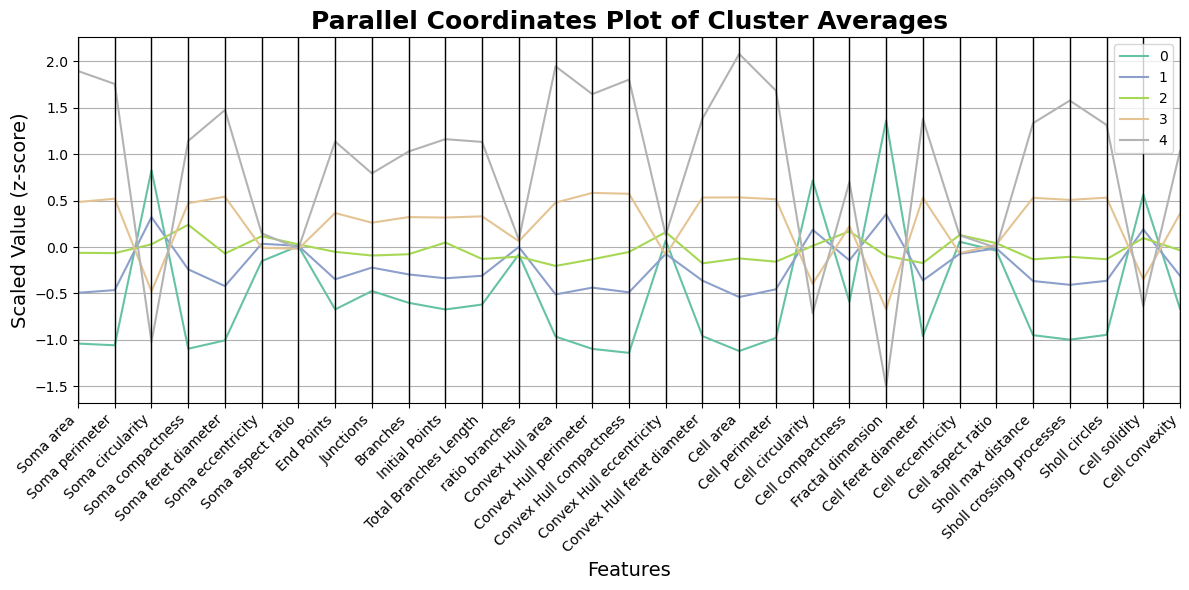

Parallel coordinates plot saved to: /Users/alexlawson/Masters-Data-Final/Morphoglia/PVN_all/Morphoglia/MorphoGlia/Data/Plots/Heatmap_Python/parallel_coordinates_cluster_averages.png


In [24]:
# %% [code]
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates
from sklearn.preprocessing import StandardScaler

# Set file path (adjust if needed)
data_path = "/Users/alexlawson/Masters-Data-Final/Morphoglia/PVN_all/Morphoglia/MorphoGlia/Data/Morphology_HDBSCAN_30_0.1_150_5_reformatted.csv"
output_dir = "/Users/alexlawson/Masters-Data-Final/Morphoglia/PVN_all/Morphoglia/MorphoGlia/Data/Plots/Heatmap_Python"
os.makedirs(output_dir, exist_ok=True)

# Load the data from the CSV file
df = pd.read_csv(data_path)

# Filter out noise: Remove rows where Clusters equals -1
df = df[df['Clusters'] != -1].copy()

# Define the variables to be used (list matches your previous settings)
variables = [
    'Soma_area', 'Soma_perimeter', 'Soma_circularity', 'Soma_compactness', 
    'Soma_feret_diameter', 'Soma_eccentricity', 'Soma_aspect_ratio', 
    'End_Points', 'Junctions', 'Branches', 'Initial_Points', 'Total_Branches_Length', 
    'ratio_branches', 'Convex_Hull_area', 'Convex_Hull_perimeter', 
    'Convex_Hull_compactness', 'Convex_Hull_eccentricity', 'Convex_Hull_feret_diameter',
    'Cell_area', 'Cell_perimeter', 'Cell_circularity', 'Cell_compactness', 'Fractal_dimension',
    'Cell_feret_diameter', 'Cell_eccentricity', 'Cell_aspect_ratio', 'Sholl_max_distance', 
    'Sholl_crossing_processes', 'Sholl_circles', 'Cell_solidity', 'Cell_convexity'
]

# Subset the data to include only the "Clusters" and chosen feature variables
df_filtered = df[['Clusters'] + variables].copy()

# Replace underscores with spaces in feature names
new_attribute_labels = [var.replace("_", " ") for var in variables]
df_filtered.columns = ['Clusters'] + new_attribute_labels

# Ensure Clusters is treated as a categorical variable with a specific order (0, 1, 2, 3, 4)
df_filtered['Clusters'] = pd.Categorical(df_filtered['Clusters'], categories=[0, 1, 2, 3, 4], ordered=True)

# Scale the features (all columns except "Clusters")
scaler = StandardScaler()
df_scaled = df_filtered.copy()
df_scaled.iloc[:, 1:] = scaler.fit_transform(df_scaled.iloc[:, 1:])

# Aggregate data by Cluster (compute the mean for each feature per cluster)
agg_data = df_scaled.groupby("Clusters", as_index=False).mean()
print("Aggregated Data by Cluster:")
print(agg_data.head())

# Create the parallel coordinates plot
plt.figure(figsize=(12, 6))
parallel_coordinates(agg_data, 'Clusters', colormap=plt.get_cmap("Set2"))
plt.title("Parallel Coordinates Plot of Cluster Averages", fontsize=18, fontweight='bold')
plt.xlabel("Features", fontsize=14)
plt.ylabel("Scaled Value (z-score)", fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

# Save the plot
output_file = os.path.join(output_dir, "parallel_coordinates_cluster_averages.png")
plt.savefig(output_file, dpi=300)
plt.show()

print("Parallel coordinates plot saved to:", output_file)


/var/folders/54/7byrywl93ynbd42k_q4n9b6w0000gn/T/ipykernel_36700/3324784086.py:41: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.17387001 -0.74435902 -0.6557831  ...  0.56025928 -1.52352692
 -0.53643079]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_scaled.iloc[:, 1:] = scaler.fit_transform(df_scaled.iloc[:, 1:])
/var/folders/54/7byrywl93ynbd42k_q4n9b6w0000gn/T/ipykernel_36700/3324784086.py:41: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.99859101 -0.70909923 -0.70909923 ... -0.13011566  0.15937612
 -1.28808279]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_scaled.iloc[:, 1:] = scaler.fit_transform(df_scaled.iloc[:, 1:])
/var/folders/54/7byrywl93ynbd42k_q4n9b6w0000gn/T/ipykernel_36700/3324784086.py:41: FutureWarning: Setting an item of incompa

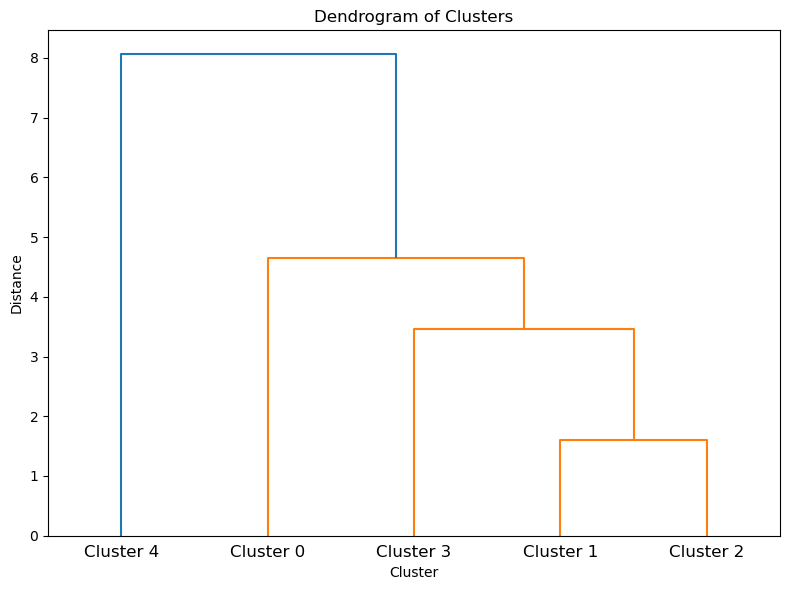

Dendrogram saved to: /Users/alexlawson/Masters-Data-Final/Morphoglia/PVN_all/Morphoglia/MorphoGlia/Data/Plots/Heatmap_Python/dendrogram_clusters.png


In [25]:
# %% [code]
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram

# Set file paths (adjust these paths as needed)
data_path = "/Users/alexlawson/Masters-Data-Final/Morphoglia/PVN_all/Morphoglia/MorphoGlia/Data/Morphology_HDBSCAN_30_0.1_150_5_reformatted.csv"
output_dir = "/Users/alexlawson/Masters-Data-Final/Morphoglia/PVN_all/Morphoglia/MorphoGlia/Data/Plots/Heatmap_Python"
os.makedirs(output_dir, exist_ok=True)

# --- Data Loading and Filtering ---
df = pd.read_csv(data_path)
df = df[df['Clusters'] != -1].copy()  # Filter out noise

# --- Define variables and prepare data ---
variables = [
    'Soma_area', 'Soma_perimeter', 'Soma_circularity', 'Soma_compactness', 
    'Soma_feret_diameter', 'Soma_eccentricity', 'Soma_aspect_ratio', 
    'End_Points', 'Junctions', 'Branches', 'Initial_Points', 'Total_Branches_Length', 
    'ratio_branches', 'Convex_Hull_area', 'Convex_Hull_perimeter', 
    'Convex_Hull_compactness', 'Convex_Hull_eccentricity', 'Convex_Hull_feret_diameter',
    'Cell_area', 'Cell_perimeter', 'Cell_circularity', 'Cell_compactness', 'Fractal_dimension',
    'Cell_feret_diameter', 'Cell_eccentricity', 'Cell_aspect_ratio', 'Sholl_max_distance', 
    'Sholl_crossing_processes', 'Sholl_circles', 'Cell_solidity', 'Cell_convexity'
]
df_filtered = df[['Clusters'] + variables].copy()

# Replace underscores with spaces in feature names for prettier labels
new_labels = [var.replace("_", " ") for var in variables]
df_filtered.columns = ['Clusters'] + new_labels

# Ensure the Clusters column is categorical with a specified order (0, 1, 2, 3, 4)
df_filtered['Clusters'] = pd.Categorical(df_filtered['Clusters'], categories=[0, 1, 2, 3, 4], ordered=True)

# --- Scale the Features ---
scaler = StandardScaler()
df_scaled = df_filtered.copy()
df_scaled.iloc[:, 1:] = scaler.fit_transform(df_scaled.iloc[:, 1:])

# --- Aggregate Data by Cluster ---
agg_data = df_scaled.groupby("Clusters", as_index=False).mean()
agg_data = agg_data.sort_values("Clusters")

# --- Transpose Data for the Heatmap ---
# We want features as rows and clusters as columns.
heatmap_data = agg_data.set_index("Clusters").T
heatmap_data.columns = ["Cluster " + str(c) for c in heatmap_data.columns]

# --- Hierarchical Clustering of Clusters ---
# Perform clustering on the transposed data (i.e., clustering the clusters)
Z = linkage(heatmap_data.T, method="average")  # You can change the method (e.g., 'ward', 'complete')

# --- Plot the Dendrogram ---
plt.figure(figsize=(8, 6))
dendrogram(Z, labels=heatmap_data.columns, orientation='top', leaf_rotation=0)
plt.title("Dendrogram of Clusters")
plt.xlabel("Cluster")
plt.ylabel("Distance")
plt.tight_layout()

# Save the dendrogram
dendro_output = os.path.join(output_dir, "dendrogram_clusters.png")
plt.savefig(dendro_output, dpi=300)
plt.show()

print("Dendrogram saved to:", dendro_output)


/var/folders/54/7byrywl93ynbd42k_q4n9b6w0000gn/T/ipykernel_36700/1727812366.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Clusters", y=feature, data=df, palette="Set3")


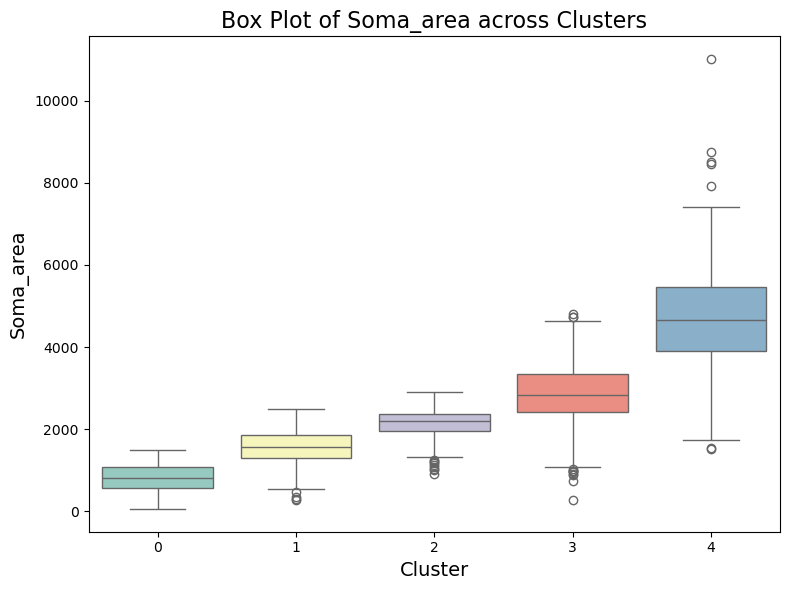

/var/folders/54/7byrywl93ynbd42k_q4n9b6w0000gn/T/ipykernel_36700/1727812366.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Clusters", y=feature, data=df, palette="Set3", inner="quartile")


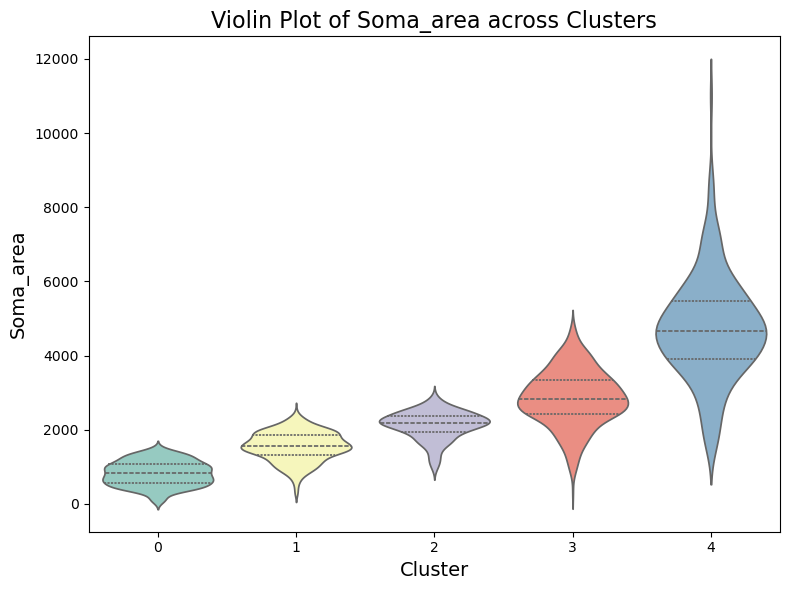

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Example Data Preparation ---
# Adjust this portion to load your actual data file.
data_path = "/Users/alexlawson/Masters-Data-Final/Morphoglia/PVN_all/Morphoglia/MorphoGlia/Data/Morphology_HDBSCAN_30_0.1_150_5_reformatted.csv"
df = pd.read_csv(data_path)

# Filter out noise: remove rows where Clusters == -1
df = df[df['Clusters'] != -1].copy()

# Ensure that Clusters is treated as a categorical variable with an appropriate order.
df['Clusters'] = pd.Categorical(df['Clusters'], categories=[0, 1, 2, 3, 4], ordered=True)

# Optionally, filter by sex if you want separate comparisons
# For example, for males:
df_males = df[df['tissue'] == "M"].copy()
# And for females:
df_females = df[df['tissue'] == "F"].copy()

# --- Plotting a Single Feature across Clusters ---
# Let's assume we are interested in 'Soma_area'. If your column names have underscores, make sure they match!
feature = "Soma_area"

# Create a boxplot of the selected feature across clusters.
plt.figure(figsize=(8, 6))
sns.boxplot(x="Clusters", y=feature, data=df, palette="Set3")
plt.title(f"Box Plot of {feature} across Clusters", fontsize=16)
plt.xlabel("Cluster", fontsize=14)
plt.ylabel(feature, fontsize=14)
plt.tight_layout()
plt.show()

# Now, create a violin plot for the same feature.
plt.figure(figsize=(8, 6))
sns.violinplot(x="Clusters", y=feature, data=df, palette="Set3", inner="quartile")
plt.title(f"Violin Plot of {feature} across Clusters", fontsize=16)
plt.xlabel("Cluster", fontsize=14)
plt.ylabel(feature, fontsize=14)
plt.tight_layout()
plt.show()


/var/folders/54/7byrywl93ynbd42k_q4n9b6w0000gn/T/ipykernel_7713/2979469682.py:71: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-1.27280886e-01 -7.04301775e-01 -6.14711690e-01 -5.84342169e-01
 -3.31353729e-02  9.86521277e-01  9.74535651e-02  4.64924763e-01
  3.98871056e-01  1.58631931e+00 -6.88195594e-02  2.56134310e-01
  1.75655080e-01 -1.11336888e-01 -4.25661425e-01  1.00018756e+00
  2.75478661e+00  1.20290411e+00 -1.20236191e+00  5.15793709e-01
 -9.41184035e-01  8.98611850e-02 -5.44102555e-01  1.23267658e-01
 -8.31853761e-01 -5.79786741e-01  1.25529153e+00  3.93556390e-01
 -2.20667162e-01 -2.35092684e-01 -6.71654541e-01  6.22846269e-01
  8.84024145e-01  4.12699523e-02  2.66291881e+00  2.05628763e+00
  5.62866466e-01  4.84664951e-01  7.89878632e-01  7.16232545e-01
 -5.97249215e-01 -3.26201245e-01  2.52777444e+00  1.71083434e+00
 -3.55052290e-01 -3.58848480e-01 -8.76648804e-01  2.62116072e+00
  4.35314480e-01  8.

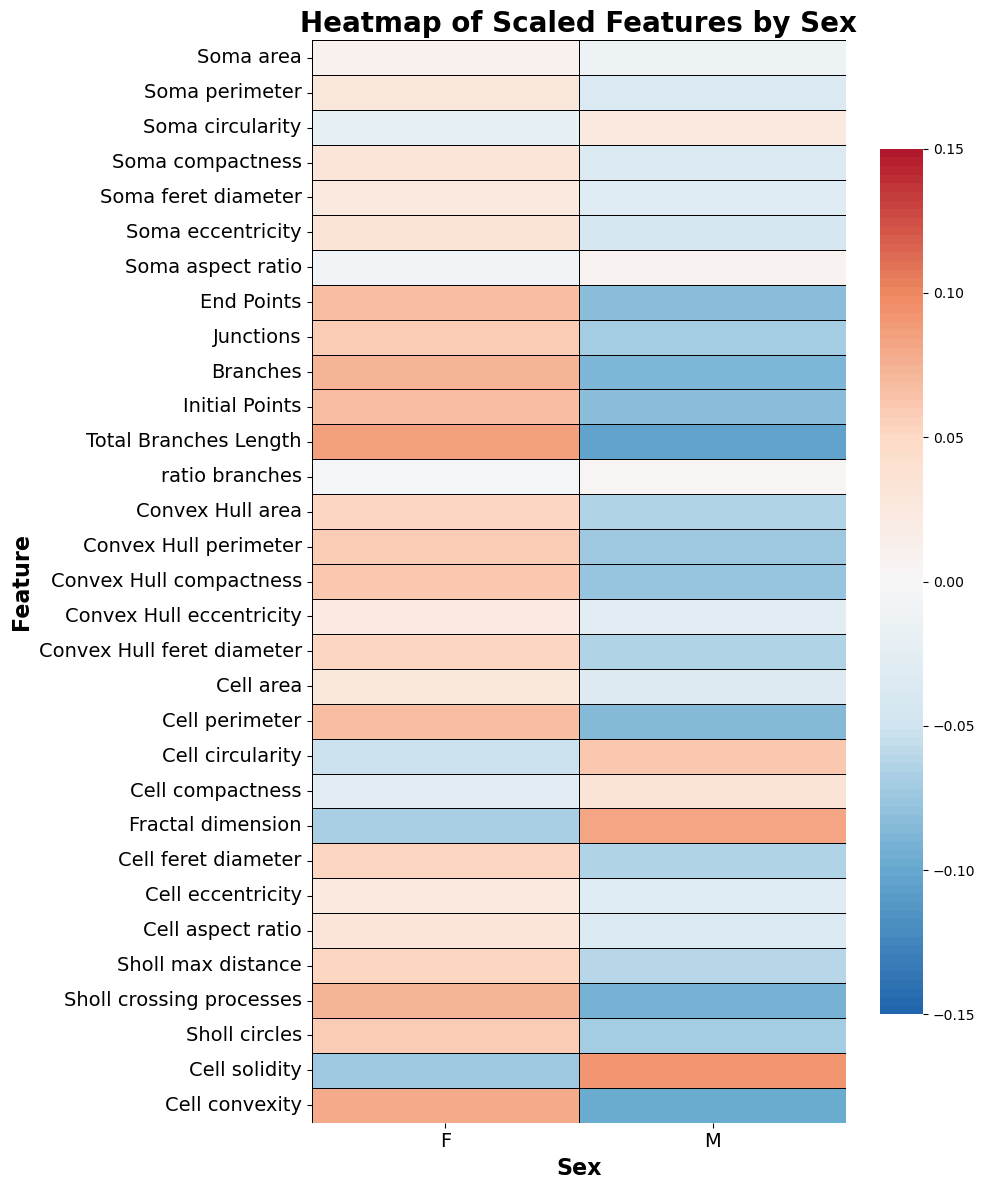

Heatmap saved to: /Users/alexlawson/Masters-Data-Final/Morphoglia/PVN_all/Morphoglia/MorphoGlia/Data/Plots/Heatmap_Python/heatmap_sex_CON.png


In [2]:
# %% [markdown]
# # Heatmap of Scaled Features by Treatment (Males)
# This notebook creates a heatmap of scaled morphological features for male samples.
# The data are first aggregated by "treatment" (which plays the role of cluster here),
# then transposed so that rows are features and columns are treatment groups.
# A fixed diverging color scale (from -1 to 1) is used.

# %% [code]
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import LinearSegmentedColormap

# Set file paths (adjust these paths as needed)
data_path = "/Users/alexlawson/Masters-Data-Final/Morphoglia/PVN_all/Morphoglia/MorphoGlia/Data/Morphology_HDBSCAN_30_0.1_150_5.csv"
output_dir = "/Users/alexlawson/Masters-Data-Final/Morphoglia/PVN_all/Morphoglia/MorphoGlia/Data/Plots/Heatmap_Python"
os.makedirs(output_dir, exist_ok=True)

# %% [markdown]
# ## Load and Filter Data

# %% [code]
# Load the CSV data
df = pd.read_csv(data_path)

# Remove noise: filter out rows where Clusters equals -1
df = df[df['Clusters'] != -1]

# Filter for controls (CON)
df = df[df['treatment'] == "CON"].copy()

# %% [markdown]
# ## Select and Prepare Variables
# We will use a set of feature variables. In this example they are:
# 
# - Soma_area, Soma_perimeter, Soma_circularity, …, Cell_convexity  
# 
# Replace underscores in variable names with spaces for nicer labels.

# %% [code]
# List of variables to be used
variables = [
    'Soma_area', 'Soma_perimeter', 'Soma_circularity', 'Soma_compactness', 
    'Soma_feret_diameter', 'Soma_eccentricity', 'Soma_aspect_ratio', 
    'End_Points', 'Junctions', 'Branches', 'Initial_Points', 'Total_Branches_Length', 
    'ratio_branches', 'Convex_Hull_area', 'Convex_Hull_perimeter', 
    'Convex_Hull_compactness', 'Convex_Hull_eccentricity', 'Convex_Hull_feret_diameter',
    'Cell_area', 'Cell_perimeter', 'Cell_circularity', 'Cell_compactness', 'Fractal_dimension',
    'Cell_feret_diameter', 'Cell_eccentricity', 'Cell_aspect_ratio', 'Sholl_max_distance', 
    'Sholl_crossing_processes', 'Sholl_circles', 'Cell_solidity', 'Cell_convexity'
]

# Subset the data: keep treatment and the selected variables
df_filtered = df[['tissue'] + variables].copy()

# Replace underscores with spaces in the variable names (for prettier row names)
new_labels = [var.replace("_", " ") for var in variables]
df_filtered.columns = ['tissue'] + new_labels

# %% [markdown]
# ## Scale the Data and Aggregate by Treatment
# We'll scale each numeric column (z‑score) and then compute the average for each treatment group.

# %% [code]
# Scale numeric columns (all except "treatment")
scaler = StandardScaler()
df_scaled = df_filtered.copy()
df_scaled.iloc[:, 1:] = scaler.fit_transform(df_scaled.iloc[:, 1:])

# Group by sex and take the mean for each feature
agg_data = df_scaled.groupby('tissue', as_index=False).mean()

# Optionally, sort the sex. For instance, if you want a manual order:
desired_order = []
if "M" in agg_data['tissue'].values and "F" in agg_data['tissue'].values:
    desired_order = ["F", "M"]
else:
    desired_order = sorted(agg_data['tissue'].unique())
agg_data = agg_data.set_index('tissue').loc[desired_order].reset_index()

# %% [markdown]
# ## Transpose Data for Heatmap
# Now we have features as rows and treatment groups as columns.

# %% [code]
# Create a matrix for the heatmap: rows = features, columns = treatment groups
heatmap_data = agg_data.set_index('tissue').T
# The row indices are feature labels (already in new_labels order)
# The column names are treatment groups (ordered as desired)

# %% [markdown]
# ## Define a Uniform Diverging Color Scale
# We use a custom colormap based on a smooth transition from blue → white → red.
# The color range is fixed from -1 to 1.

# %% [code]
colors = [
    "#2166AC",  # Deep blue
    "#67A9CF",  # Mid blue
    "#D1E5F0",  # Pale blue
    "#F7F7F7",  # White (neutral midpoint)
    "#FDDBC7",  # Pale red
    "#EF8A62",  # Medium red
    "#B2182B"   # Deep red
]
custom_cmap = LinearSegmentedColormap.from_list("custom_diverging", colors, N=100)
vmin, vmax = -0.15, 0.15

# %% [markdown]
# ## Plot the Heatmap
# We use seaborn’s heatmap. Adjust font sizes as desired.

# %% [code]
plt.figure(figsize=(10, 12))
ax = sns.heatmap(heatmap_data, cmap=custom_cmap, annot=False, fmt=".2f",
                 vmin=vmin, vmax=vmax, linewidths=0.5, linecolor='black',
                 cbar_kws={'shrink': 0.8})

ax.set_title("Heatmap of Scaled Features by Sex",
             fontsize=20, fontweight='bold')
ax.set_xlabel("Sex", fontsize=16, fontweight='bold')
ax.set_ylabel("Feature", fontsize=16, fontweight='bold')
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
plt.tight_layout()

# Save the figure
output_file = os.path.join(output_dir, "heatmap_sex_CON.png")
plt.savefig(output_file, dpi=300)
plt.show()

print("Heatmap saved to:", output_file)
